# Thousand Year Flood  
An exercise in plotting near-surface temperature and geopotential height anomalies at 500 hPa.

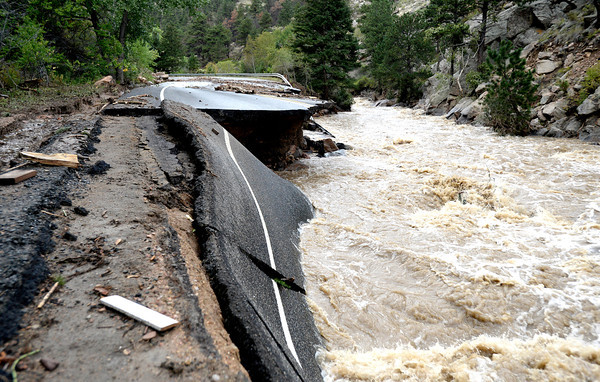

From September 11 to September 15, 2013, Colorado's Front Range saw a historic deluge of rainfall that caused torrential flooding in the region as well as many broken precipitation records, with 0.5 - 1.5 feet of rain in the span of about 30 hours from the 11th through the 12th. For some areas, this flood was a one in a thousand year event. Over 1918 square miles were affected; almost 20000 people were evacuated; 2000 homes were destroyed. 

Below, Python functions are used with plotting libraries to look at anomalies in two atmospheric variables (temperature and geopotential height at 500 hPa) on September 12, a day that saw much of the flooding occur.  

Source: https://www.weather.gov/bou/Number1September2013Floods

In [1]:
# import libraries
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.util import add_cyclic_point
import datetime

In [2]:
# define paths in for files
pathin1 = '/Volumes/eas-shared/eas2900/2022/data_2022/air.sig995.20100101-20201231.3.nc'
pathin2 = '/Volumes/eas-shared/eas2900/2022/data_2022/hgt.20100101-20201231.3.nc'

# open netcdf dataset files as xarray dataframes
air_ds = xr.open_dataset(pathin1)
height_ds = xr.open_dataset(pathin2)

## Plotting a Map of Near-Surface Temperature and Geopotential Height Anomalies

In [3]:
def plot_anomaly_map(ds, dataset_data, date, title, label, level):
    """
    Returns: None. Generates contour plot of an atmospheric variable's anomalies from long-term means on a given day.
    
    Parameter ds: A valid netcdf file opened as a xarray dataframe for a given variable, with latitude, longitude, and time information.
    Parameter dataset_data: The data for a given variable given by latitude, longitude, and time, extracted from parameter ds.
                            Included in case unit conversions or transformations are necessary before plotting.
    Parameter date: A day of interest to plot anomalies. Type string with format YYYY-MM-DD.
    Parameter title: Title to be given to the plot. Type string.
    Parameter label: Label to be applied to the colorbar on the plot. Type string.
    Parameter level: A specification of how many levels are wanted on the plot's colorbar. Type integer or array of integers.
    """
    lat = ds.lat # extract latitude coordinate
    lon = ds.lon # extract longitude coordinate
    time = ds.time # extract time coordinate
    
    clim = dataset_data.groupby('time.dayofyear').mean(dim='time') # group by day and calculate mean
    anom = dataset_data.groupby('time.dayofyear') - clim # subtract mean to find anomalies
    
    # select date of interest and find anomalies for that day
    day = date
    anom_day = anom.sel(time = day)
    cyc, lon_cyc = add_cyclic_point(anom_day, coord = lon)
    
    # setting up figure with Mercator projection
    fig = plt.figure(figsize = (20, 30))
    ax  = plt.axes(projection = ccrs.Mercator())

    # contour plot
    plt.contourf(lon_cyc, lat, cyc, \
                 transform = ccrs.PlateCarree(), \
                 cmap = matplotlib.cm.bwr, \
                 levels = level, \
                 extend = 'both')

    # adding colorbar and labels
    ax.coastlines() # add coastlines
    ax.add_feature(cf.BORDERS.with_scale('50m'), edgecolor = [.3,.3,.3], linewidth = 0.5) # add country borders
    cb = plt.colorbar(extendfrac = 'auto', shrink = 0.25) # add a colorbar, save it as an object 'cb'
    cb.set_label(label = label) # add a colorbar label by amending a label to the object 'cb'
    plt.title(title + day) # add a title

    # placing a marker and label at Boulder, CO
    marked_lat = 40.014984
    marked_lon = -105.270546
    plt.plot(marked_lon, marked_lat, 'gx', markeredgewidth = 2, markersize = 6, label = 'Boulder, CO', transform = ccrs.PlateCarree()) # plot a marker
    plt.text(marked_lon+0.5, marked_lat-0.5, 'Boulder, CO', fontsize = 10, color = 'g', transform = ccrs.PlateCarree()); # plot text next to the marker
    ax.set_extent((-125, -85, 25, 50)) # zooming into area of interest
    
    plt.show()

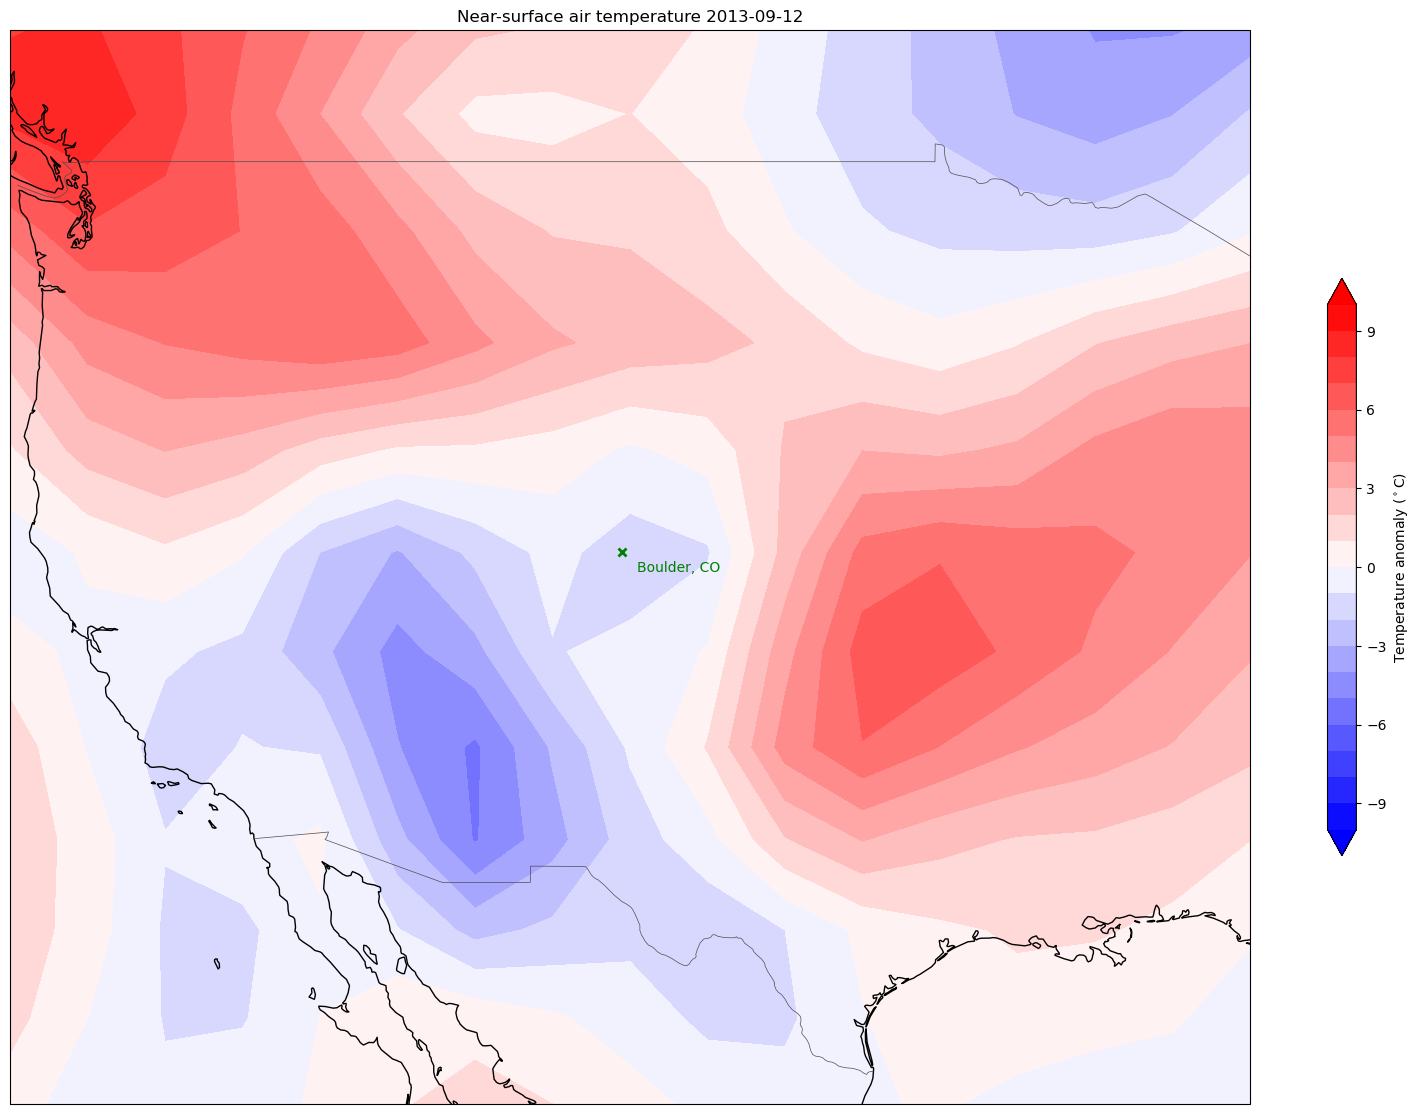

In [4]:
# calling plotting function on near-surface air temperature
fig = plot_anomaly_map(air_ds, air_ds.air[:] - 273.15, '2013-09-12', 'Near-surface air temperature ', 'Temperature anomaly ($^\circ$C)', np.linspace(-10,10,21))

Visible in this plot is the extremely moist airmass situated over the region, causing torrential downpours to stall over Boulder and cooling down the area. Also visible is the movement of subtropical water vapor up to the north and east.

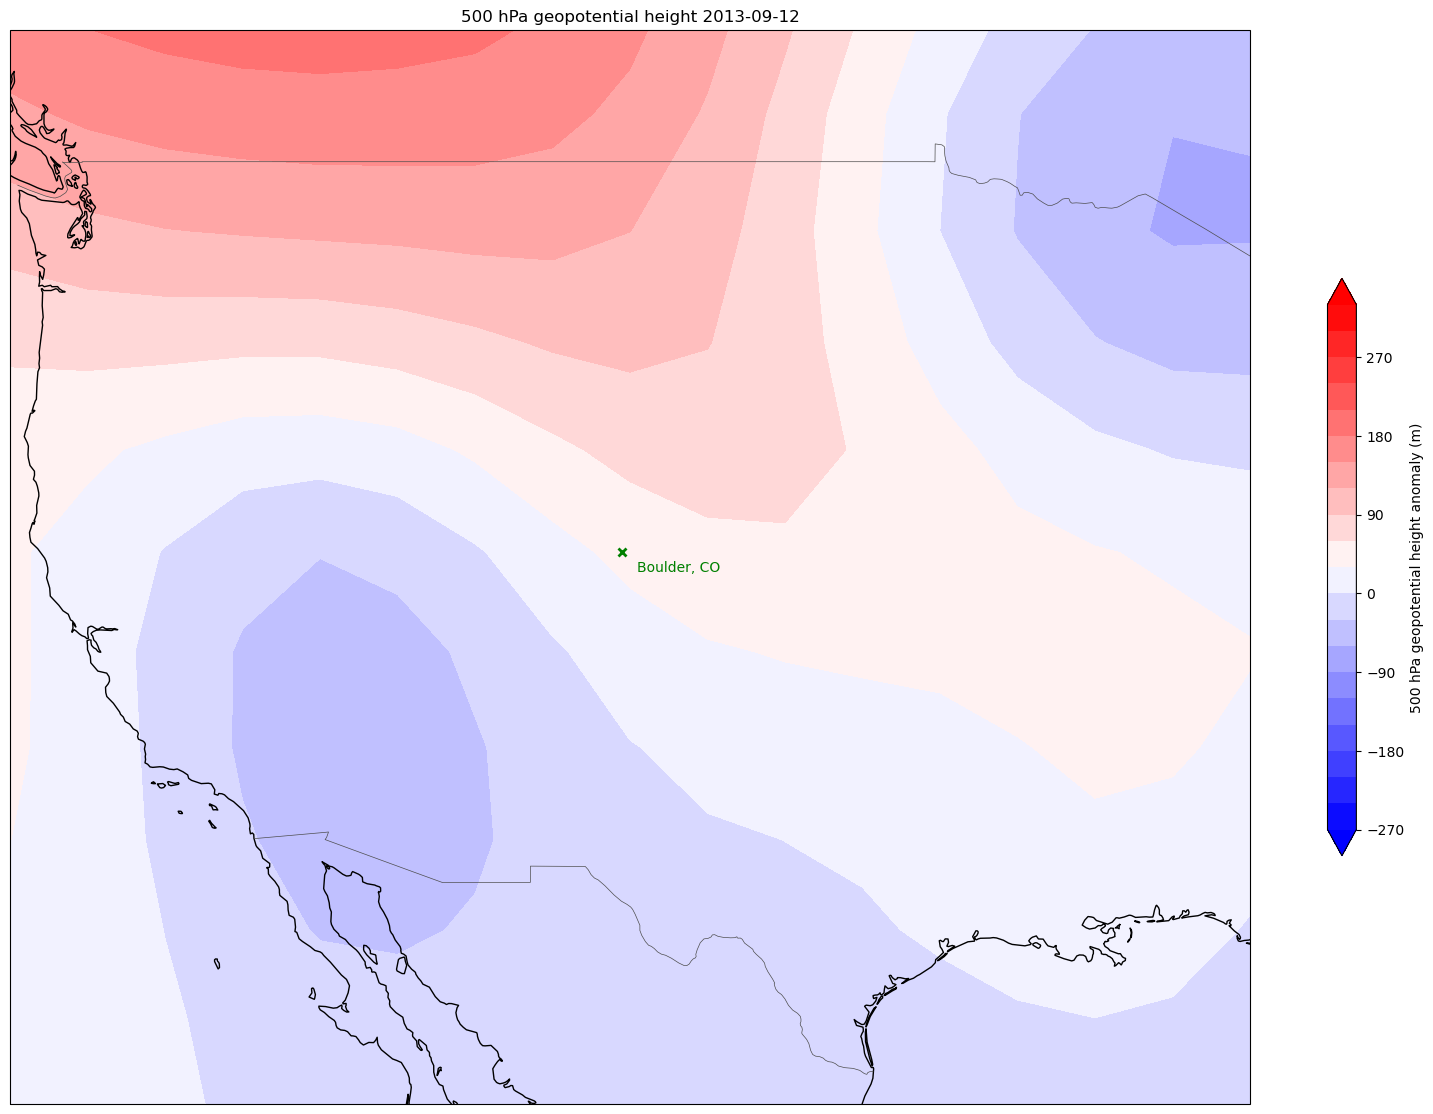

In [5]:
# calling plotting function on geopotential height data for a level of 500 hPa
plot_anomaly_map(height_ds, height_ds.sel(level=500.).hgt[:], '2013-09-12', '500 hPa geopotential height ', '500 hPa geopotential height anomaly (m)', 21)


Here, we can see an upper level low in the desert southwest making its way slowly northward.

## Time Series Plots

In [6]:
# limiting the datasets to the coordinate of interest and then to the time period of interest
marked_lat = 40.014984
marked_lon = -105.270546
date = '2013-09-11'
date =  datetime.datetime.strptime(date, "%Y-%m-%d" )

coordinate_limited_air_ds = air_ds.sel(lat = marked_lat, lon = marked_lon, method = "nearest")
coordinate_limited_hgt_ds = height_ds.sel(lat = marked_lat, lon = marked_lon, method = "nearest")

date_limited_air_ds = coordinate_limited_air_ds.sel(time=slice(date - datetime.timedelta(days=10), date + datetime.timedelta(days=10)))
date_limited_hgt_ds = coordinate_limited_hgt_ds.sel(time=slice(date - datetime.timedelta(days=10), date + datetime.timedelta(days=10)))

In [7]:
def plot_anomaly_time(ds, dataset_data, date, title, label):
    """
    Returns: None. Generates line plot of an atmospheric variable's anomalies from long-term means over a given period of time.
    
    Parameter ds: A valid netcdf file opened as a xarray dataframe for a given variable, with latitude, longitude, and time information, limited to
                  the time period of interest.
    Parameter dataset_data: The data for a given variable limited to one latitude and longitude value and given by time, extracted from parameter ds.
                            Included in case unit conversions are necessary before plotting.
    Parameter date: A day of interest to plot anomalies. Type string with format YYYY-MM-DD.
    Parameter title: Title to be given to the plot. Type string.
    Parameter label: Label to be applied to the y-axis on the plot. Type string.
    """
    date =  datetime.datetime.strptime(date, "%Y-%m-%d" )
    data = dataset_data
    
    clim = data.groupby('time.dayofyear').mean(dim='time') # group by day and calculate mean (a crude climatology)
    anom = data.groupby('time.dayofyear') - clim # subtract the climatology to create anomalies
    
    anom = anom.sel(time=slice(date - datetime.timedelta(days=10), date + datetime.timedelta(days=10)))

    plt.plot(ds.time, anom, color="b")

    plt.xlabel('Day of Year')
    plt.ylabel(label)
    plt.title(title)
    
    plt.axhline(y = 0, ls = 'dashed', color = "black")
    plt.plot(ds.time[10], anom[10], 'rx', markersize=15) # adding red cross to line plot where the day of interest occurred
    
    plt.show()

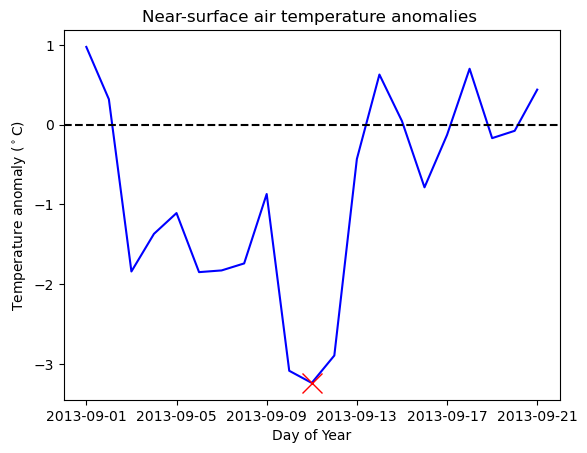

In [8]:
plot_anomaly_time(date_limited_air_ds, coordinate_limited_air_ds.air[:] - 273.15, '2013-09-12', 'Near-surface air temperature anomalies ', 'Temperature anomaly ($^\circ$C)')



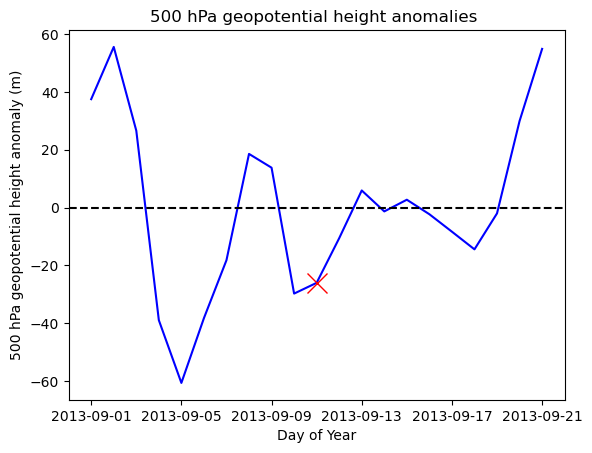

In [9]:
plot_anomaly_time(date_limited_hgt_ds, coordinate_limited_hgt_ds.sel(level=500.).hgt[:], '2013-09-12', '500 hPa geopotential height anomalies ', '500 hPa geopotential height anomaly (m)')
